# **NOTES**
* This file is a copy of mvp_model.ipynb with some changes (each done separately!)
* Features RobustScaled (=> leads to worse results)
* Features MinMax Scaled (=> leads to worse results)
* Sales moving average has been removed from the pipeline (=> leads to worse results)

# Imports

In [362]:
import pandas as pd
import numpy as np

from mamimo.time_utils import add_time_features, PowerTrend
from mamimo.carryover import ExponentialCarryover
from mamimo.saturation import ExponentialSaturation

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, learning_curve, RandomizedSearchCV
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, RobustScaler, MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin, OneToOneFeatureMixin

from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FeatureUnion

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

import holidays

import seaborn as sns
import matplotlib.pyplot as plt

# Load DataFrame

In [363]:
df = pd.read_csv('../../raw_data/df_clean.csv')
df = df.drop(columns='Unnamed: 0')
df['Day'] = pd.to_datetime(df['Day'])
df.set_index('Day', inplace=True)
df = df.rename(columns={"fb_costs": "facebook", "google_costs": "google", "tt_costs": "tiktok"})
df['day'] = df.index # we will use this in our column transformer
df = df.drop(columns = ['fb_impressions', 'fb_clicks', 'google_impressions', 'google_clicks', 'tt_impressions', 'tt_clicks'])

# Split Data

In [364]:
n_splits = 5  # Number of splits for cross-validation
tscv = TimeSeriesSplit(n_splits=n_splits)

for train_index, test_index in tscv.split(df):
    train_df = df.iloc[train_index]
    test_df = df.iloc[test_index]

train_df = train_df.assign(trend=range(len(train_df)))

y_train = train_df['total_sales']
X_train = train_df.drop(columns = ['total_sales', 'orders'])

test_df = test_df.assign(trend=range(len(test_df)))
y_test = test_df['total_sales']
X_test = test_df.drop(columns = ['total_sales', 'orders'])

# Scaling

## RobustScaler

In [365]:
rb = RobustScaler()
rb.fit(train_df[['facebook']])
train_df['facebook'] = rb.transform(train_df[['facebook']])
test_df['facebook'] = rb.transform(test_df[['facebook']])

rb.fit(train_df[['google']])
train_df['google'] = rb.transform(train_df[['google']])
test_df['google'] = rb.transform(test_df[['google']])

rb.fit(train_df[['tiktok']])
train_df['tiktok'] = rb.transform(train_df[['tiktok']])
test_df['tiktok'] = rb.transform(test_df[['tiktok']])

## MinMax Scaler

In [366]:
"""minmax = MinMaxScaler()
minmax.fit(train_df[['facebook']])
train_df['facebook'] = minmax.transform(train_df[['facebook']])
test_df['facebook'] = minmax.transform(test_df[['facebook']])

minmax.fit(train_df[['google']])
train_df['google'] = minmax.transform(train_df[['google']])
test_df['google'] = minmax.transform(test_df[['google']])


minmax.fit(train_df[['tiktok']])
train_df['tiktok'] = minmax.transform(train_df[['tiktok']])
test_df['tiktok'] = minmax.transform(test_df[['tiktok']])"""


"minmax = MinMaxScaler()\nminmax.fit(train_df[['facebook']])\ntrain_df['facebook'] = minmax.transform(train_df[['facebook']])\ntest_df['facebook'] = minmax.transform(test_df[['facebook']])\n\nminmax.fit(train_df[['google']])\ntrain_df['google'] = minmax.transform(train_df[['google']])\ntest_df['google'] = minmax.transform(test_df[['google']])\n\n\nminmax.fit(train_df[['tiktok']])\ntrain_df['tiktok'] = minmax.transform(train_df[['tiktok']])\ntest_df['tiktok'] = minmax.transform(test_df[['tiktok']])"

# Baseline Model

In [367]:
baseline = train_df.shift(1) # baseline['total_sales'] is equivalent to y_pred

y_pred = baseline['total_sales']
y_true = train_df['total_sales']

# MSE
mse = ((y_true - y_pred) ** 2).mean()

# Calculate TSS (Total Sum of Squares)
mean_y_true = np.mean(y_true)
tss = np.sum((y_true - mean_y_true)**2)

# Calculate RSS (Residual Sum of Squares)
rss = np.sum((y_true - y_pred)**2)

# Calculate R-squared (Coefficient of Determination)
r_squared = 1 - (rss / tss)

f"{mse} is our MSE to beat; {r_squared} is our R squared to beat!"

'595453.442743578 is our MSE to beat; 0.6398209085770498 is our R squared to beat!'

# Check for stationarity

In [368]:
from statsmodels.tsa.stattools import adfuller

adfuller(train_df.total_sales)[1] # close enough to 0.05, so our data is stationary enough

0.062198848540433505

# Create Custom Tranformers

## Time Features

### Holidays

In [369]:
class AddHolidaysTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        # This transformer doesn't need to learn any parameters during fitting,
        # so we simply return self.
        return self

    def transform(self, X):
        """Creates a new column with row value = 1 if the day is a Friday or Saturday and 0 if not."""
        df = X.copy()  # Create a copy of the input DataFrame to avoid modifying it directly
        de_holiday_list = []
        for holiday in holidays.Germany(years=[2021,2022,2023]).items():
            de_holiday_list.append(holiday)
        de_holidays_df = pd.DataFrame(de_holiday_list, columns=["date", "holiday"])
        de_holidays_df['date'] = pd.to_datetime(de_holidays_df['date'])
        de_holidays_df.set_index('date', inplace=True)
        
        at_holiday_list = []
        for holiday in holidays.Austria(years=[2021,2022,2023]).items():
            at_holiday_list.append(holiday)
        at_holidays_df = pd.DataFrame(at_holiday_list, columns=["date", "holiday"])
        at_holidays_df['date'] = pd.to_datetime(at_holidays_df['date'])
        at_holidays_df.set_index('date', inplace=True)

        # add DE holidays to df
        merged_df = df.merge(de_holidays_df, how='left', left_index=True, right_index=True)
        merged_df['de_holiday'] = merged_df.index.isin(de_holidays_df.index).astype(int)
        merged_df.drop(columns=['holiday'], inplace=True)
        
        # add AT holidays to df
        at_holidays_df['at_holiday'] = 1 # add a 1 column to austrian holidays dataframe to help us merge with DE holidays
        merged_df = merged_df.merge(at_holidays_df[['at_holiday']], how='left', left_index=True, right_index=True)
        merged_df.head() # creates two columns (at_holiday_x, at_holiday_y), we only need one
        merged_df['at_holiday'].fillna(0, inplace=True) # replace NaN (no holiday) with 0
        merged_df['at_holiday'] = merged_df['at_holiday'].astype(int) # convert 1 and 0 to integers
        
        # combine columns
        merged_df['holiday'] = (merged_df['at_holiday'] | merged_df['de_holiday']).astype(int)
        merged_df = merged_df.drop(columns = ['de_holiday', 'at_holiday']) # drop individual DE and AT rows
        
        return merged_df[['holiday']]#.reset_index(drop=True)


#### Does it work?

In [370]:
holidays_transformer = AddHolidaysTransformer()
df = train_df.copy()
holidays_transformer.fit_transform(df)

,holiday
Day,
2021-07-01,0
2021-07-02,0
2021-07-03,0
2021-07-04,0
2021-07-05,0
...,...
2023-04-12,0
2023-04-13,0
2023-04-14,0


#### Yes!

### Weekends

In [371]:
class AddWeekendsTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        # This transformer doesn't need to learn any parameters during fitting,
        # so we simply return self.
        return self

    def transform(self, X):
        """Creates a new column with row value = 1 if the day is a Friday or Saturday and 0 if not."""
        df = X.copy()  # Create a copy of the input DataFrame to avoid modifying it directly
        weekday_values = df.index.weekday
        df['fri_sat'] = ((weekday_values == 4) | (weekday_values == 5)).astype(int)
        return df[['fri_sat']]

#### Does it work?

In [372]:
weekends_transformer = AddWeekendsTransformer()
df = train_df.copy()
weekends_transformer.fit_transform(df)

,fri_sat
Day,
2021-07-01,0
2021-07-02,1
2021-07-03,1
2021-07-04,0
2021-07-05,0
...,...
2023-04-12,0
2023-04-13,0
2023-04-14,1


#### Yes!

### Cyclical months

In [373]:
class AddMonthsTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, power=1):
        self.power = power
        
    def fit(self, X, y=None):
        # This transformer doesn't need to learn any parameters during fitting,
        # so we simply return self.
        return self

    def transform(self, X):
        df = X.copy()  # Create a copy of the input DataFrame to avoid modifying it directly
        df = (df
        .pipe(add_time_features, month=True) 
        )
        
        months_in_a_year = 12
        df['sin_MonthYear'] = np.sin(2*np.pi*(df['month'])/months_in_a_year)
        df['cos_MonthYear'] = np.cos(2*np.pi*(df['month'])/months_in_a_year)
        df.drop(columns=['month'], inplace=True)
        
        return df[['sin_MonthYear', 'cos_MonthYear']]

#### Does it work?

In [374]:
add_months_transformer = AddMonthsTransformer()
df = train_df.copy()
add_months_transformer.fit_transform(df)

,sin_MonthYear,cos_MonthYear
Day,,
2021-07-01,-0.500000,-0.866025
2021-07-02,-0.500000,-0.866025
2021-07-03,-0.500000,-0.866025
2021-07-04,-0.500000,-0.866025
2021-07-05,-0.500000,-0.866025
...,...,...
2023-04-12,0.866025,-0.500000
2023-04-13,0.866025,-0.500000
2023-04-14,0.866025,-0.500000


#### Yes!

### Power Trend

In [375]:
class AddTrendTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, power=1):
        self.power = power
        
    def fit(self, X, y=None):
        # This transformer doesn't need to learn any parameters during fitting,
        # so we simply return self.
        return self

    def transform(self, X):
        df = X.copy()  # Create a copy of the input DataFrame to avoid modifying it directly

        df['trend'] = PowerTrend(self.power).fit_transform(df[['trend']])
        
        return df[['trend']]

#### Does it work?

In [376]:
add_trend_transformer = AddTrendTransformer(power = 1)
df = train_df.copy()
add_trend_transformer.fit_transform(df)

,trend
Day,
2021-07-01,0
2021-07-02,1
2021-07-03,2
2021-07-04,3
2021-07-05,4
...,...
2023-04-12,650
2023-04-13,651
2023-04-14,652


#### Yes!

## Cost Features

### FB Cumulative Spending

In [377]:
class AddCumSpendingFBTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, period = 'weekly', carryover = False):
        self.period = period
        self.carryover = carryover
        
    def fit(self, X, y=None):
        # This transformer doesn't need to learn any parameters during fitting,
        # so we simply return self.
        return self
    
    def transform(self, X):
        df = X.copy()  # Create a copy of the input DataFrame to avoid modifying it directly
        """Add a cumulative spending column. Select period (weekly, monthly, or quarterly).
        Indicate whether you would like to carry over the previous period in subsequent sums with sum_prev_data."""
        w_cumulative_spending = (
                    df[['facebook']]
                    .resample('W-Mon')  # Resample to weekly, starting on Mondays
                    .sum()
                )
        w_cumulative_spending_carryover = (
                    df[['facebook']]
                    .resample('W-Mon')
                    .sum()
                    .cumsum()
                )
        m_cumulative_spending = (
                    df[['facebook']]
                    .resample('M')  # Resample to monthly
                    .sum()
                )
        m_cumulative_spending_carryover = (
                    df[['facebook']]
                    .resample('M')
                    .sum()
                    .cumsum()
                )

        q_cumulative_spending = (
                    df[['facebook']]
                    .resample('Q')  # Resample to quarterly
                    .sum()
                )
        q_cumulative_spending_carryover = (
                    df[['facebook']]
                    .resample('Q')
                    .sum()
                    .cumsum()
                )

        week_values = {
            1: 6, # tuesday
            2: 5, # wednesday
            3: 4, # thursday
            4: 3, # friday
            5: 2, # saturday
            6: 1 # sunday
        }
        
        first_date = df.index[0]
        day_of_week = first_date.dayofweek
        cum_channels = ['facebook_cumulative']
        cost_channels = ['facebook']
        
        if self.carryover == False:
            if self.period == 'weekly':
                cumulative_spending_daily = w_cumulative_spending.reindex(df.index, method='ffill')                   
                # Merge the daily cumulative values back to the original DataFrame:
                df = df.join(cumulative_spending_daily, rsuffix='_cumulative')
                if day_of_week in week_values:
                    idx = (week_values[day_of_week])
                    selection = pd.DataFrame(df.loc[df.index[0:idx], 'facebook'])
                    df['facebook_cumulative'][0:idx] = selection['facebook'].sum()
            elif self.period == 'monthly':
                cumulative_spending_monthly = m_cumulative_spending.reindex(df.index, method='bfill')
                df = df.join(cumulative_spending_monthly, rsuffix='_cumulative')
            elif self.period == 'quarterly':
                cumulative_spending_quarterly = q_cumulative_spending.reindex(df.index, method='bfill')
                df = df.join(cumulative_spending_quarterly, rsuffix='_cumulative')
            else:
                raise ValueError('Invalid period option. Choose "weekly", "monthly", or "quarterly".')            

        elif self.carryover == True:
            if self.period == 'weekly':
                cumulative_spending_filled = w_cumulative_spending_carryover.reindex(df.index, method='ffill')
                cumulative_spending_filled.columns = [f'{col}_cum_carryover' for col in cumulative_spending_filled.columns]
                df = df.join(cumulative_spending_filled)
                if day_of_week in week_values:
                    idx = (week_values[day_of_week])
                    selection = pd.DataFrame(df.loc[df.index[0:idx], 'facebook'])
                    df['facebook_cum_carryover'][0:idx] = selection['facebook'].sum()
            elif self.period == 'monthly':
                cumulative_spending_filled = m_cumulative_spending_carryover.reindex(df.index, method='bfill')
                cumulative_spending_filled.columns = [f'{col}_cum_carryover' for col in cumulative_spending_filled.columns]
                df = df.join(cumulative_spending_filled)
            elif self.period == 'quarterly':
                cumulative_spending_filled = q_cumulative_spending_carryover.reindex(df.index, method='bfill')
                cumulative_spending_filled.columns = [f'{col}_cum_carryover' for col in cumulative_spending_filled.columns]
                df = df.join(cumulative_spending_filled)
            else:
                raise ValueError('Invalid period option. Choose "weekly", "monthly", or "quarterly".')
                
        else:
            raise ValueError('Invalid carryover option. Choose True or False.')
            

        return df[['facebook_cumulative']]

#### Does it work?

In [378]:
cum_spending_FB_transformer = AddCumSpendingFBTransformer(period = 'weekly', carryover = False)
df = train_df.copy()
cum_spending_FB_transformer .fit_transform(df)

/var/folders/6z/35ch39_x42sc8_3pss6wly180000gn/T/ipykernel_1502/4171319227.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['facebook_cumulative'][0:idx] = selection['facebook'].sum()


,facebook_cumulative
Day,
2021-07-01,-2.122260
2021-07-02,-2.122260
2021-07-03,-2.122260
2021-07-04,-2.122260
2021-07-05,-2.646795
...,...
2023-04-12,0.857441
2023-04-13,0.857441
2023-04-14,0.857441


#### Yes!

### Google Cumulative Spending

In [379]:
class AddCumSpendingGGTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, period = 'weekly', carryover = False):
        self.period = period
        self.carryover = carryover
        
    def fit(self, X, y=None):
        # This transformer doesn't need to learn any parameters during fitting,
        # so we simply return self.
        return self
    
    def transform(self, X):
        df = X.copy()  # Create a copy of the input DataFrame to avoid modifying it directly
        # Check if the required columns exist
        """Add a cumulative spending column. Select period (weekly, monthly, or quarterly).
        Indicate whether you would like to carry over the previous period in subsequent sums with sum_prev_data."""
        w_cumulative_spending = (
                    df[['google']]
                    .resample('W-Mon')  # Resample to weekly, starting on Mondays
                    .sum()
                )
        w_cumulative_spending_carryover = (
                    df[['google']]
                    .resample('W-Mon')
                    .sum()
                    .cumsum()
                )
        m_cumulative_spending = (
                    df[['google']]
                    .resample('M')  # Resample to monthly
                    .sum()
                )
        m_cumulative_spending_carryover = (
                    df[['google']]
                    .resample('M')
                    .sum()
                    .cumsum()
                )

        q_cumulative_spending = (
                    df[['google']]
                    .resample('Q')  # Resample to quarterly
                    .sum()
                )
        q_cumulative_spending_carryover = (
                    df[['google']]
                    .resample('Q')
                    .sum()
                    .cumsum()
                )

        week_values = {
            1: 6, # tuesday
            2: 5, # wednesday
            3: 4, # thursday
            4: 3, # friday
            5: 2, # saturday
            6: 1 # sunday
        }
        
        first_date = df.index[0]
        day_of_week = first_date.dayofweek
        cum_channels = ['google_cumulative']
        cost_channels = ['google']
        
        if self.carryover == False:
            if self.period == 'weekly':
                cumulative_spending_daily = w_cumulative_spending.reindex(df.index, method='ffill')                   
                # Merge the daily cumulative values back to the original DataFrame:
                df = df.join(cumulative_spending_daily, rsuffix='_cumulative')
                if day_of_week in week_values:
                    idx = (week_values[day_of_week])
                    selection = pd.DataFrame(df.loc[df.index[0:idx], 'google'])
                    df['google_cumulative'][0:idx] = selection['google'].sum()
            elif self.period == 'monthly':
                cumulative_spending_monthly = m_cumulative_spending.reindex(df.index, method='bfill')
                df = df.join(cumulative_spending_monthly, rsuffix='_cumulative')
            elif self.period == 'quarterly':
                cumulative_spending_quarterly = q_cumulative_spending.reindex(df.index, method='bfill')
                df = df.join(cumulative_spending_quarterly, rsuffix='_cumulative')
            else:
                raise ValueError('Invalid period option. Choose "weekly", "monthly", or "quarterly".')            

        elif self.carryover == True:
            if self.period == 'weekly':
                cumulative_spending_filled = w_cumulative_spending_carryover.reindex(df.index, method='ffill')
                cumulative_spending_filled.columns = [f'{col}_cum_carryover' for col in cumulative_spending_filled.columns]
                df = df.join(cumulative_spending_filled)
                if day_of_week in week_values:
                    idx = (week_values[day_of_week])
                    df['google_cum_carryover'][0:idx] = selection['google'].sum()
            elif self.period == 'monthly':
                cumulative_spending_filled = m_cumulative_spending_carryover.reindex(df.index, method='bfill')
                cumulative_spending_filled.columns = [f'{col}_cum_carryover' for col in cumulative_spending_filled.columns]
                df = df.join(cumulative_spending_filled)
            elif self.period == 'quarterly':
                cumulative_spending_filled = q_cumulative_spending_carryover.reindex(df.index, method='bfill')
                cumulative_spending_filled.columns = [f'{col}_cum_carryover' for col in cumulative_spending_filled.columns]
                df = df.join(cumulative_spending_filled)
            else:
                raise ValueError('Invalid period option. Choose "weekly", "monthly", or "quarterly".')
                
        else:
            raise ValueError('Invalid carryover option. Choose True or False.')
            

        return df[['google_cumulative']]

#### Does it work?

In [380]:
cum_spending_GG_transformer = AddCumSpendingGGTransformer(period = 'weekly', carryover = False)
df = train_df.copy()
cum_spending_GG_transformer .fit_transform(df)

/var/folders/6z/35ch39_x42sc8_3pss6wly180000gn/T/ipykernel_1502/3875066929.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['google_cumulative'][0:idx] = selection['google'].sum()


,google_cumulative
Day,
2021-07-01,-1.594127
2021-07-02,-1.594127
2021-07-03,-1.594127
2021-07-04,-1.594127
2021-07-05,-1.995008
...,...
2023-04-12,13.216076
2023-04-13,13.216076
2023-04-14,13.216076


#### Yes!

### TikTok Cumulative Spending

In [381]:
class AddCumSpendingTTTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, period = 'weekly', carryover = False):
        self.period = period
        self.carryover = carryover
        
    def fit(self, X, y=None):
        # This transformer doesn't need to learn any parameters during fitting,
        # so we simply return self.
        return self
    
    def transform(self, X):
        df = X.copy()  # Create a copy of the input DataFrame to avoid modifying it directly
        """Add a cumulative spending column. Select period (weekly, monthly, or quarterly).
        Indicate whether you would like to carry over the previous period in subsequent sums with sum_prev_data."""
        w_cumulative_spending = (
                    df[['tiktok']]
                    .resample('W-Mon')  # Resample to weekly, starting on Mondays
                    .sum()
                )
        w_cumulative_spending_carryover = (
                    df[['tiktok']]
                    .resample('W-Mon')
                    .sum()
                    .cumsum()
                )
        m_cumulative_spending = (
                    df[['tiktok']]
                    .resample('M')  # Resample to monthly
                    .sum()
                )
        m_cumulative_spending_carryover = (
                    df[['tiktok']]
                    .resample('M')
                    .sum()
                    .cumsum()
                )

        q_cumulative_spending = (
                    df[['tiktok']]
                    .resample('Q')  # Resample to quarterly
                    .sum()
                )
        q_cumulative_spending_carryover = (
                    df[['tiktok']]
                    .resample('Q')
                    .sum()
                    .cumsum()
                )

        week_values = {
            1: 6, # tuesday
            2: 5, # wednesday
            3: 4, # thursday
            4: 3, # friday
            5: 2, # saturday
            6: 1 # sunday
        }
        
        first_date = df.index[0]
        day_of_week = first_date.dayofweek
        cum_channels = ['tiktok']
        cost_channels = ['tiktok']
        
        if self.carryover == False:
            if self.period == 'weekly':
                cumulative_spending_daily = w_cumulative_spending.reindex(df.index, method='ffill')                   
                # Merge the daily cumulative values back to the original DataFrame:
                df = df.join(cumulative_spending_daily, rsuffix='_cumulative')
                if day_of_week in week_values:
                    idx = (week_values[day_of_week])
                    selection = pd.DataFrame(df.loc[df.index[0:idx], 'tiktok'])
                    df['tiktok_cumulative'][0:idx] = selection['tiktok'].sum()
            elif self.period == 'monthly':
                cumulative_spending_monthly = m_cumulative_spending.reindex(df.index, method='bfill')
                df = df.join(cumulative_spending_monthly, rsuffix='_cumulative')
            elif self.period == 'quarterly':
                cumulative_spending_quarterly = q_cumulative_spending.reindex(df.index, method='bfill')
                df = df.join(cumulative_spending_quarterly, rsuffix='_cumulative')
            else:
                raise ValueError('Invalid period option. Choose "weekly", "monthly", or "quarterly".')            

        elif self.carryover == True:
            if self.period == 'weekly':
                cumulative_spending_filled = w_cumulative_spending_carryover.reindex(df.index, method='ffill')
                cumulative_spending_filled.columns = [f'{col}_cum_carryover' for col in cumulative_spending_filled.columns]
                df = df.join(cumulative_spending_filled)
                if day_of_week in week_values:
                    idx = (week_values[day_of_week])
                    selection = pd.DataFrame(df.loc[df.index[0:idx], 'tiktok'])
                    df['tiktok_cum_carryover'][0:idx] = selection['tiktok'].sum()
            elif self.period == 'monthly':
                cumulative_spending_filled = m_cumulative_spending_carryover.reindex(df.index, method='bfill')
                cumulative_spending_filled.columns = [f'{col}_cum_carryover' for col in cumulative_spending_filled.columns]
                df = df.join(cumulative_spending_filled)
            elif self.period == 'quarterly':
                cumulative_spending_filled = q_cumulative_spending_carryover.reindex(df.index, method='bfill')
                cumulative_spending_filled.columns = [f'{col}_cum_carryover' for col in cumulative_spending_filled.columns]
                df = df.join(cumulative_spending_filled)
            else:
                raise ValueError('Invalid period option. Choose "weekly", "monthly", or "quarterly".')
                
        else:
            raise ValueError('Invalid carryover option. Choose True or False.')
            

        return df[['tiktok_cumulative']]

#### Does it work?

In [382]:
cum_spending_TT_transformer = AddCumSpendingTTTransformer(period = 'weekly', carryover = False)
df = train_df.copy()
cum_spending_TT_transformer .fit_transform(df)

/var/folders/6z/35ch39_x42sc8_3pss6wly180000gn/T/ipykernel_1502/3296021123.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tiktok_cumulative'][0:idx] = selection['tiktok'].sum()


,tiktok_cumulative
Day,
2021-07-01,0.0
2021-07-02,0.0
2021-07-03,0.0
2021-07-04,0.0
2021-07-05,0.0
...,...
2023-04-12,0.0
2023-04-13,0.0
2023-04-14,0.0


#### Yes!

## Sales Features

### Lag

In [383]:
class AddSalesLagTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, period=7):
        self.period = period

    def fit(self, X, y=None):
        # This transformer doesn't need to learn any parameters during fitting,
        # so we simply return self.
        return self

    def transform(self, X):
        """Adds a sales lag column with the specified period."""
        df = X.copy()  # Create a copy of the input DataFrame to avoid modifying it directly
        df['sales_lag'] = df['total_sales'].shift(self.period)
        df['sales_lag'] = df['sales_lag'].bfill()  # Backfill missing values
        return df[['sales_lag']]


In [384]:
sales_lag_transformer = AddSalesLagTransformer(period = 7)
df = train_df.copy()
sales_lag_transformer.fit_transform(df)

,sales_lag
Day,
2021-07-01,414.85
2021-07-02,414.85
2021-07-03,414.85
2021-07-04,414.85
2021-07-05,414.85
...,...
2023-04-12,3173.95
2023-04-13,1865.47
2023-04-14,2133.27


### Moving Average

In [385]:
class AddSalesMovAvgTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, window_size=7):
        self.window_size = window_size

    def fit(self, X, y=None):
        # This transformer doesn't need to learn any parameters during fitting,
        # so we simply return self.
        return self

    def transform(self, X):
        """Adds a sales moving average column. Indicate the window size (default = 7)"""
        df = X.copy()  # Create a copy of the input DataFrame to avoid modifying it directly
        df['sales_moving_avg'] = df['total_sales'].rolling(window=self.window_size, center=True).mean()
        df['sales_moving_avg'] = df['sales_moving_avg'].bfill()  # Backfill missing values at beginning of df
        df['sales_moving_avg'] = df['sales_moving_avg'].ffill()  # Forwardfill missing values at end of df
        return df[['sales_moving_avg']]

#### Does it work?

In [386]:
sales_mov_avg_transformer = AddSalesMovAvgTransformer(window_size = 7)
df = train_df.copy()
sales_mov_avg_transformer.fit_transform(df)

,sales_moving_avg
Day,
2021-07-01,407.245714
2021-07-02,407.245714
2021-07-03,407.245714
2021-07-04,407.245714
2021-07-05,445.885714
...,...
2023-04-12,3026.895714
2023-04-13,3237.397143
2023-04-14,3237.397143


#### Yes!

### Exponential Smoothing

In [387]:
class AddSalesExpSmoothingTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, alpha = 0.5):
        self.alpha = alpha
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        """Adds a sales (exponential smoothing) column. Indicate the alpha value (default = 0.5)"""
        df = X.copy()
        smoothed_series = [df['total_sales'].iloc[0]]
        for i in range(1, len(df)):
            smoothed_value = self.alpha * df['total_sales'].iloc[i] + (1 - self.alpha) * smoothed_series[-1]
            smoothed_series.append(smoothed_value)
        df['smoothed_sales'] = smoothed_series
        return df[['smoothed_sales']]

#### Does it work?

In [388]:
sales_exp_smoothing_transformer = AddSalesExpSmoothingTransformer(alpha = 0.5)
df = train_df.copy()
sales_exp_smoothing_transformer.fit_transform(df)

,smoothed_sales
Day,
2021-07-01,414.850000
2021-07-02,322.400000
2021-07-03,391.145000
2021-07-04,449.752500
2021-07-05,424.816250
...,...
2023-04-12,3845.153512
2023-04-13,3379.391756
2023-04-14,2557.425878


#### Yes!

## Adstock
* comes from `mamimo` package, explained [here](https://towardsdatascience.com/an-upgraded-marketing-mix-modeling-in-python-5ebb3bddc1b6)

In [389]:
adstock = ColumnTransformer(
    [
     ('facebook_pipe', Pipeline([
            ('carryover', ExponentialCarryover()),
            ('saturation', ExponentialSaturation())
     ]), ['facebook']),
     ('google_pipe', Pipeline([
            ('carryover', ExponentialCarryover()),
            ('saturation', ExponentialSaturation())
     ]), ['google']),
     ('tiktok_pipe', Pipeline([
            ('carryover', ExponentialCarryover()),
            ('saturation', ExponentialSaturation())
     ]), ['tiktok'])
])

def create_df(array: np.array):
    columns = ['orders', 'total_sales', 'facebook', 'google', 'tiktok', 'holiday',
       'fri_sat', 'trend', 'sin_MonthYear', 'cos_MonthYear',
       'google_cumulative', 'tiktok_cumulative', 'facebook_cumulative',
       'sales_lag', 'sales_moving_avg', 'smoothed_sales']
    columns_ = ['facebook','google','tiktok']
    df = pd.DataFrame(array, columns = columns_)
    datetime_series = pd.Series(
        pd.date_range("2021-07-01", periods=len(df), freq="D")
        )
    df = pd.concat([df,datetime_series],axis=1)
    df = df.set_index(0)
    df = df.rename(index={0: 'Day'})
    return df

In [390]:
df = train_df.copy()
df
#adstock.fit_transform(df)

,orders,total_sales,facebook,google,tiktok,day,trend
Day,,,,,,,
2021-07-01,10,414.85,-0.525231,-0.395082,0.0,2021-07-01,0
2021-07-02,6,229.95,-0.535392,-0.397504,0.0,2021-07-02,1
2021-07-03,10,459.89,-0.537981,-0.398385,0.0,2021-07-03,2
2021-07-04,17,508.36,-0.523656,-0.403157,0.0,2021-07-04,3
2021-07-05,13,399.88,-0.524535,-0.400881,0.0,2021-07-05,4
...,...,...,...,...,...,...,...
2023-04-12,83,3718.12,0.426199,1.127032,0.0,2023-04-12,650
2023-04-13,75,2913.63,0.421414,0.965168,0.0,2023-04-13,651
2023-04-14,53,1735.46,0.088144,0.775922,0.0,2023-04-14,652


# Instantiate Custom Transformers

In [391]:

holidays_transformer = AddHolidaysTransformer()
weekends_transformer = AddWeekendsTransformer()
add_months_transformer = AddMonthsTransformer()
add_trend_transformer = AddTrendTransformer(power = 1)
cum_spending_FB_transformer = AddCumSpendingFBTransformer(period = 'weekly', carryover = False)
cum_spending_GG_transformer = AddCumSpendingGGTransformer(period = 'weekly', carryover = False)
cum_spending_TT_transformer = AddCumSpendingTTTransformer(period = 'weekly', carryover = False)
sales_lag_transformer = AddSalesLagTransformer(period = 7)
sales_mov_avg_transformer = AddSalesMovAvgTransformer(window_size = 7)
sales_exp_smoothing_transformer = AddSalesExpSmoothingTransformer(alpha = 0.5)

# Debug CT

## Time CT

In [392]:
time_features = ColumnTransformer(
    [
     ('holidays_pipe', Pipeline([
            ('add_holidays', AddHolidaysTransformer())
     ]), ['day']),
     ('weekends_pipe', Pipeline([
            ('add_weekends', AddWeekendsTransformer())
     ]), ['day']),
     ('months_pipe', Pipeline([
            ('add_months', AddMonthsTransformer())
     ]), ['day']),
     ('trend_pipe', Pipeline([
         ('add_trend', AddTrendTransformer())
     ]), ['trend'])
])

In [393]:
df = train_df.copy()
transformed_df = time_features.fit_transform(df)
transformed_df = pd.DataFrame(transformed_df, columns = ['holiday', 'weekends', 'sin', 'cos', 'trend'])
transformed_df

,holiday,weekends,sin,cos,trend
0,0.0,0.0,-0.500000,-0.866025,0.0
1,0.0,1.0,-0.500000,-0.866025,1.0
2,0.0,1.0,-0.500000,-0.866025,2.0
3,0.0,0.0,-0.500000,-0.866025,3.0
4,0.0,0.0,-0.500000,-0.866025,4.0
...,...,...,...,...,...
650,0.0,0.0,0.866025,-0.500000,650.0
651,0.0,0.0,0.866025,-0.500000,651.0
652,0.0,1.0,0.866025,-0.500000,652.0
653,0.0,1.0,0.866025,-0.500000,653.0


#### It works!

## Cost CT

In [394]:
cum_spending_feature = ColumnTransformer(
    [
     ('facebook_pipe', Pipeline([
            ('add_cum_spending_FB', cum_spending_FB_transformer)
     ]), ['facebook']),
     ('google_pipe', Pipeline([
            ('add_cum_spending_GG', cum_spending_GG_transformer)
     ]), ['google']),
     ('tiktok_pipe', Pipeline([
            ('add_cum_spending_TT', cum_spending_TT_transformer)
     ]), ['tiktok'])
])

In [395]:
df = train_df.copy()
transformed_df = cum_spending_feature.fit_transform(df)
transformed_df = pd.DataFrame(transformed_df, columns = ['facebook', 'google', 'tiktok'])
transformed_df

,facebook,google,tiktok
0,-2.122260,-1.594127,0.0
1,-2.122260,-1.594127,0.0
2,-2.122260,-1.594127,0.0
3,-2.122260,-1.594127,0.0
4,-2.646795,-1.995008,0.0
...,...,...,...
650,0.857441,13.216076,0.0
651,0.857441,13.216076,0.0
652,0.857441,13.216076,0.0
653,0.857441,13.216076,0.0


#### It works!

## Sales CT

In [396]:
sales_lag_transformer = AddSalesLagTransformer(period = 7)
sales_mov_avg_transformer = AddSalesMovAvgTransformer(window_size = 7)
sales_exp_smoothing_transformer = AddSalesExpSmoothingTransformer(alpha = 0.5)

sales_features = ColumnTransformer(
    [
     ('sales_lag_pipe', Pipeline([
            ('add_sales_lag', sales_lag_transformer)
     ]), ['total_sales']),
     ('sales_exp_smoothing_pipe', Pipeline([
            ('add_sales_exp_smoothing', sales_exp_smoothing_transformer)
     ]), ['total_sales'])
])

sales_preprocessing = Pipeline([
    ('sales_features', sales_features)
])

In [397]:
df = train_df.copy()
transformed_df = sales_preprocessing.fit_transform(df)
transformed_df = pd.DataFrame(transformed_df)#, columns = ['facebook', 'google', 'tiktok'])
transformed_df

,0,1
0,414.85,414.850000
1,414.85,322.400000
2,414.85,391.145000
3,414.85,449.752500
4,414.85,424.816250
...,...,...
650,3173.95,3845.153512
651,1865.47,3379.391756
652,2133.27,2557.425878
653,1767.01,1939.047939


#### It works!

# Pipeline

In [398]:
(list(np.linspace(0,2,10)))

[0.0,
 0.2222222222222222,
 0.4444444444444444,
 0.6666666666666666,
 0.8888888888888888,
 1.1111111111111112,
 1.3333333333333333,
 1.5555555555555554,
 1.7777777777777777,
 2.0]

In [399]:

model = LinearRegression()

adstock_pipeline = Pipeline([
    ('adstock', adstock)
])

time_preprocessing = Pipeline([
    ('time_features', time_features)
])

cost_preprocessing = Pipeline([
    ('cum_spending_feature', cum_spending_feature)
])

sales_preprocessing = Pipeline([
    ('sales_features', sales_features)
])

union = FeatureUnion([
    ('time_preprocessing', time_preprocessing),
    ('cost_preprocessing', cost_preprocessing),
    ('sales_preprocessing', sales_preprocessing),
    ('adstock_pipeline', adstock_pipeline)
])

pipeline = Pipeline([
    ('union', union),
    ('model', model)
])

param_grid = {
    'union__cost_preprocessing__cum_spending_feature__facebook_pipe__add_cum_spending_FB__period': ['weekly', 'monthly'],
    'union__cost_preprocessing__cum_spending_feature__facebook_pipe__add_cum_spending_FB__carryover': [True, False],
    'union__cost_preprocessing__cum_spending_feature__google_pipe__add_cum_spending_GG__period': ['weekly', 'monthly'],
    'union__cost_preprocessing__cum_spending_feature__google_pipe__add_cum_spending_GG__carryover': [True, False],
    'union__cost_preprocessing__cum_spending_feature__tiktok_pipe__add_cum_spending_TT__period': ['weekly', 'monthly'],
    'union__cost_preprocessing__cum_spending_feature__tiktok_pipe__add_cum_spending_TT__carryover': [True, False],
    'union__sales_preprocessing__sales_features__sales_lag_pipe__add_sales_lag__period': [7, 14, 21],
    'union__sales_preprocessing__sales_features__sales_exp_smoothing_pipe__add_sales_exp_smoothing__alpha': [0.2, 0.5, 0.8],
    'union__time_preprocessing__time_features__trend_pipe__add_trend__power': list(np.linspace(0,2,10))
    }

## Check pipeline output

In [400]:
tscv = TimeSeriesSplit(n_splits= 3)
random_search = RandomizedSearchCV(pipeline, param_grid, cv = tscv)
random_search.fit(train_df, y_train)

/Users/valeriajimenez/.pyenv/versions/3.10.6/envs/MMM-project-lewagon/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
27 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/valeriajimenez/.pyenv/versions/3.10.6/envs/MMM-project-lewagon/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/valeriajimenez/.pyenv/versions/3.10.6/envs/MMM-project-lewagon/lib/python3.10/site-packages/sklearn/base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
  

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
                   estimator=Pipeline(steps=[('union',
                                              FeatureUnion(transformer_list=[('time_preprocessing',
                                                                              Pipeline(steps=[('time_features',
                                                                                               ColumnTransformer(transformers=[('holidays_pipe',
                                                                                                                                Pipeline(steps=[('add_holidays',
                                                                                                                                                 AddHolidaysTransformer())]),
                                                                                                                                ['day']),
                                                                                                                               ('weekends_pipe',
                                                                                                                                Pip...
                                        'union__sales_preprocessing__sales_features__sales_exp_smoothing_pipe__add_sales_exp_smoothing__alpha': [0.2,
                                                                                                                                                 0.5,
                                                                                                                                                 0.8],
                                        'union__sales_preprocessing__sales_features__sales_lag_pipe__add_sales_lag__period': [7,
                                                                                                                              14,
                                                                                                                              21],
                                        'union__time_preprocessing__time_features__trend_pipe__add_trend__power': [0.0,
                                                                                                                   0.2222222222222222,
                                                                                                                   0.4444444444444444,
                                                                                                                   0.6666666666666666,
                                                                                                                   0.8888888888888888,
                                                                                                                   1.1111111111111112,
                                                                                                                   1.3333333333333333,
                                                                                                                   1.5555555555555554,
                                                                                                                   1.7777777777777777,
                                                                                                                   2.0]})

In [401]:
f"Best Parameters: {random_search.best_params_}"

"Best Parameters: {'union__time_preprocessing__time_features__trend_pipe__add_trend__power': 0.4444444444444444, 'union__sales_preprocessing__sales_features__sales_lag_pipe__add_sales_lag__period': 14, 'union__sales_preprocessing__sales_features__sales_exp_smoothing_pipe__add_sales_exp_smoothing__alpha': 0.8, 'union__cost_preprocessing__cum_spending_feature__tiktok_pipe__add_cum_spending_TT__period': 'weekly', 'union__cost_preprocessing__cum_spending_feature__tiktok_pipe__add_cum_spending_TT__carryover': False, 'union__cost_preprocessing__cum_spending_feature__google_pipe__add_cum_spending_GG__period': 'weekly', 'union__cost_preprocessing__cum_spending_feature__google_pipe__add_cum_spending_GG__carryover': False, 'union__cost_preprocessing__cum_spending_feature__facebook_pipe__add_cum_spending_FB__period': 'weekly', 'union__cost_preprocessing__cum_spending_feature__facebook_pipe__add_cum_spending_FB__carryover': False}"

In [402]:
# Check pipeline output as a pandas DataFrame

best_pipeline = random_search.best_estimator_

best_pipeline.fit(train_df, y_train)

pipe_df = pd.DataFrame(best_pipeline[0].transform(train_df))
pipe_df.columns = ['holiday','weekend', 'sin_months', 'cos_months', 'trend', 'cum_fb', 'cum_gg', 'cum_tt', 'sales_lag', 'sales_smoothed', 'adstock_fb', 'adstock_gg', 'adstock_tt']
pipe_df

,holiday,weekend,sin_months,cos_months,trend,cum_fb,cum_gg,cum_tt,sales_lag,sales_smoothed,adstock_fb,adstock_gg,adstock_tt
0,0.0,0.0,-0.500000,-0.866025,0.000000,-2.122260,-1.594127,0.0,414.85,414.850000,-0.690850,-0.484505,0.0
1,0.0,1.0,-0.500000,-0.866025,1.000000,-2.122260,-1.594127,0.0,414.85,266.930000,-0.708117,-0.488106,0.0
2,0.0,1.0,-0.500000,-0.866025,1.360790,-2.122260,-1.594127,0.0,414.85,421.298000,-0.712546,-0.489417,0.0
3,0.0,0.0,-0.500000,-0.866025,1.629498,-2.122260,-1.594127,0.0,414.85,490.947600,-0.688189,-0.496541,0.0
4,0.0,0.0,-0.500000,-0.866025,1.851749,-2.646795,-1.995008,0.0,414.85,418.093520,-0.689672,-0.493139,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
650,0.0,0.0,0.866025,-0.500000,17.790318,0.857441,13.216076,0.0,4359.47,3858.604189,0.347014,0.676007,0.0
651,0.0,0.0,0.866025,-0.500000,17.802477,0.857441,13.216076,0.0,4205.12,3102.624838,0.343882,0.619081,0.0
652,0.0,1.0,0.866025,-0.500000,17.814626,0.857441,13.216076,0.0,2853.65,2008.892968,0.084371,0.539721,0.0
653,0.0,1.0,0.866025,-0.500000,17.826764,0.857441,13.216076,0.0,2214.71,1458.314594,-0.203195,0.499067,0.0


## Check for collinearity

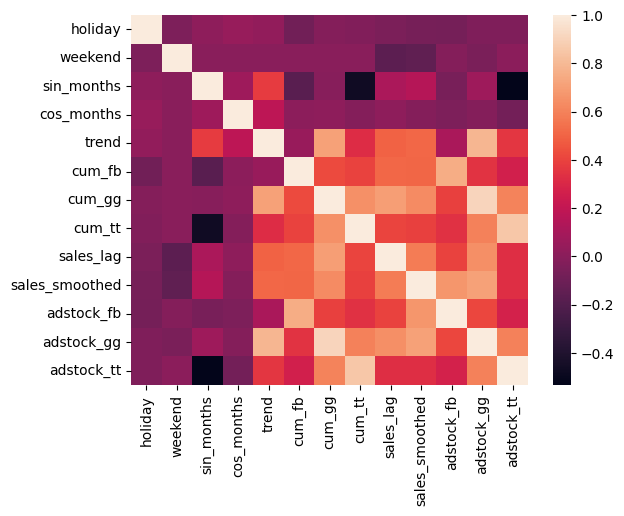

In [403]:
sns.heatmap(pipe_df.corr());

In [404]:
def plot_learning_curve(estimator, title, X, y, cv, train_sizes=np.linspace(0.1, 1.0, 10)):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, train_sizes=train_sizes, scoring='neg_mean_squared_error'
    )
    
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    
    plt.plot(train_sizes, train_scores_mean, label = 'Training score')
    plt.plot(train_sizes, test_scores_mean, label = 'Test score')
    plt.ylabel('r2 score', fontsize = 14)
    plt.xlabel('Training set size', fontsize = 14)
    plt.title('Learning curves', fontsize = 18, y = 1.03)
    plt.legend()
    
    return plt

#### Test data

In [405]:
best_pipeline = random_search.best_estimator_
y_true = test_df['total_sales']
y_pred = best_pipeline.predict(test_df)
rmse = mean_squared_error(y_true, y_pred, squared = False)
mae = mean_absolute_error(y_true, y_pred)
f"R-squared: {best_pipeline.score(test_df, y_test)}, MAE: {mae}, RMSE: {rmse}"

'R-squared: 0.9798097911963457, MAE: 248.50976910531682, RMSE: 375.83449768132596'

<module 'matplotlib.pyplot' from '/Users/valeriajimenez/.pyenv/versions/3.10.6/envs/MMM-project-lewagon/lib/python3.10/site-packages/matplotlib/pyplot.py'>

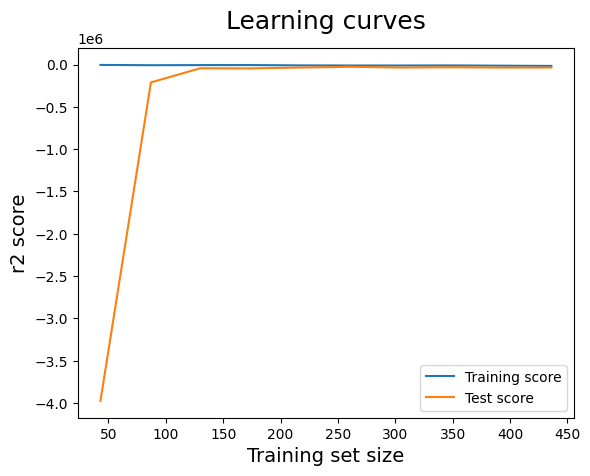

In [406]:
plot_learning_curve(best_pipeline, 'learning curve', train_df, y_train, cv = 3)

#### Train Data

In [407]:
y_true = train_df['total_sales']
y_pred = best_pipeline.predict(train_df)
rmse = mean_squared_error(y_true, y_pred, squared = False)
mae = mean_absolute_error(y_true, y_pred)
f"R-squared: {best_pipeline.score(train_df, y_train)}, MAE: {mae}, RMSE: {rmse}"

'R-squared: 0.9894283573164455, MAE: 85.41525785150948, RMSE: 132.1003956113244'

## Fit and Score on Test

#### Test data

##### Pipeline - Default Hyperparameters

In [417]:
pipeline.fit(train_df, y_train)

y_true = test_df['total_sales']
y_pred = pipeline.predict(test_df)

rmse = mean_squared_error(y_true, y_pred, squared = False)
mae = mean_absolute_error(y_true, y_pred)
f"R-squared: {pipeline.score(test_df, y_test)}, MAE: {mae}, RMSE: {rmse}"

'R-squared: 0.8812442004706835, MAE: 616.0233546008147, RMSE: 911.4936554878215'

##### Pipeline - Optimized Hyperparameters

In [418]:
best_pipeline.fit(train_df, y_train)

y_true = test_df['total_sales']
y_pred = best_pipeline.predict(test_df)

rmse = mean_squared_error(y_true, y_pred, squared = False)
mae = mean_absolute_error(y_true, y_pred)
f"R-squared: {best_pipeline.score(test_df, y_test)}, MAE: {mae}, RMSE: {rmse}"

'R-squared: 0.9798097911963457, MAE: 248.50976910531682, RMSE: 375.83449768132596'

#### Train data

##### Pipeline - Default Hyperparameters

In [419]:
pipeline.fit(train_df, y_train)

y_true = train_df['total_sales']
y_pred = pipeline.predict(train_df)

rmse = mean_squared_error(y_true, y_pred, squared = False)
mae = mean_absolute_error(y_true, y_pred)
f"R-squared: {pipeline.score(train_df, y_train)}, MAE: {mae}, RMSE: {rmse}"

'R-squared: 0.9334365523117195, MAE: 212.33537313241897, RMSE: 331.47500401064053'

##### Pipeline - Optimized Hyperparameters

In [420]:
best_pipeline.fit(train_df, y_train)

y_true = train_df['total_sales']
y_pred = best_pipeline.predict(train_df)

rmse = mean_squared_error(y_true, y_pred, squared = False)
mae = mean_absolute_error(y_true, y_pred)
f"R-squared: {best_pipeline.score(train_df, y_train)}, MAE: {mae}, RMSE: {rmse}"

'R-squared: 0.9894283573164455, MAE: 85.41525785150948, RMSE: 132.1003956113244'